In [2]:
using Catlab
using Catlab.Theories
using Catlab.CategoricalAlgebra
using Catlab.WiringDiagrams
using Catlab.WiringDiagrams.DirectedWiringDiagrams
using Catlab.Programs
using Catlab.Graphics
using Catlab.Graphics: Graphviz, to_graphviz


draw(d::WiringDiagram) = to_graphviz(d;
  orientation=LeftToRight,
  labels=true,
  label_attr=:xlabel,
  node_attrs=Graphviz.Attributes(:fontname => "Courier"),
  edge_attrs=Graphviz.Attributes(:fontname => "Courier")
)

# define signature
@present Causal(FreeSymmetricMonoidalCategory) begin
  (X, Y, UX, UY)::Ob
  f_x::Hom(UX, X)                 # UX → X
  f_y::Hom(X ⊗ UY, Y)             # X⊗UY → Y
  PUX::Hom(munit(), UX)                 # I → UX
  PUY::Hom(munit(), UY)                 # I → UY
  doX::Hom(munit(), X)
  discardX::Hom(X, munit()) 


end

# define twin program
twin = @program Causal () begin
  ux = PUX()          # exogenous source U_X
  uy = PUY()          # exogenous source U_Y

  # 
  x  = f_x(ux)
  y  = f_y(x, uy)

  # counterfactual world (sharing the same ux, uy)
  xs = f_x(ux)
  ys = f_y(xs, uy)

  return x, y, xs, ys   # output (X, Y, X*, Y*)
end
# twin_do: in the counterfactual world X is set to constant 1
# output (Y, Y*) matches the counterfactual query
twin_do_keep_fx = @program Causal () begin
  ux = PUX()
  uy = PUY()

  # actual world
  x  = f_x(ux)
  y  = f_y(x, uy)

  # conter factual world: discard f_x output, set X* = 1
  xs_unused = f_x(ux)
  _ = discardX(xs_unused)
  xs = doX()                    # do(X=1)
  ys = f_y(xs, uy)

  return y, ys                   
end



# drawings

# draw(add_junctions(wd))
# draw(twin)
# draw(add_junctions(twin))

# draw(twin_do_keep_fx)
# draw(add_junctions(wd))








WiringDiagram([], [:Y,:Y], 
[ -2 => {inputs},
  -1 => {outputs},
  1 => Box(:PUX, [], [:UX]),
  2 => Box(:PUY, [], [:UY]),
  3 => Box(:f_x, [:UX], [:X]),
  4 => Box(:f_y, [:X,:UY], [:Y]),
  5 => Box(:f_x, [:UX], [:X]),
  6 => Box(:discardX, [:X], []),
  7 => Box(:doX, [], [:X]),
  8 => Box(:f_y, [:X,:UY], [:Y]) ],
[ Wire((7,1) => (8,1)),
  Wire((3,1) => (4,1)),
  Wire((5,1) => (6,1)),
  Wire((2,1) => (4,2)),
  Wire((2,1) => (8,2)),
  Wire((1,1) => (5,1)),
  Wire((1,1) => (3,1)),
  Wire((4,1) => (-1,1)),
  Wire((8,1) => (-1,2)) ])

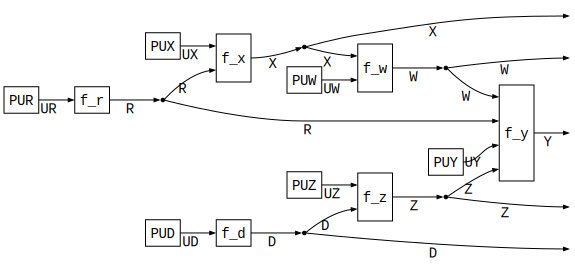

In [3]:

@present CausalR(FreeSymmetricMonoidalCategory) begin
    # objects
    (X, W, Y, Z, D, R, UX, UW, UY, UZ, UD, UR)::Ob
    
    f_r::Hom(UR, R) 
    f_x::Hom(UX ⊗ R, X)
    f_w::Hom(X ⊗ UW, W)
    f_d::Hom(UD, D)
    f_z::Hom(UZ ⊗ D, Z)
    f_y::Hom(W ⊗ R ⊗ UY ⊗ Z, Y)


    PUX::Hom(munit(), UX)
    PUW::Hom(munit(), UW)
    PUY::Hom(munit(), UY)
    PUZ::Hom(munit(), UZ)
    PUD::Hom(munit(), UD)
    PUR::Hom(munit(), UR)

    doX::Hom(munit(), X)
    doD::Hom(munit(), D)
    discardX::Hom(X, munit())
    discardD::Hom(D, munit())

    #sharp effects
    obsX_::Hom(X, munit())   # X → I  (observe X = x̃)
    obsD::Hom(D, munit())   # D → I  (observe D = d)
    obsZ::Hom(Z, munit())   # Z → I  (observe Z = z)
end

prog_d = @program CausalR () begin

    ux = PUX()
    uw = PUW()
    ur = PUR()
    uy = PUY()
    uz = PUZ()
    ud = PUD()



    r = f_r(ur)
    x = f_x(ux, r)
    w = f_w(x, uw)
    d = f_d(ud)
    z = f_z(uz, d)
    y = f_y(w, r, uy, z)


    return x, w, y, z, d
end

draw(prog_d)                    
draw(add_junctions(prog_d))


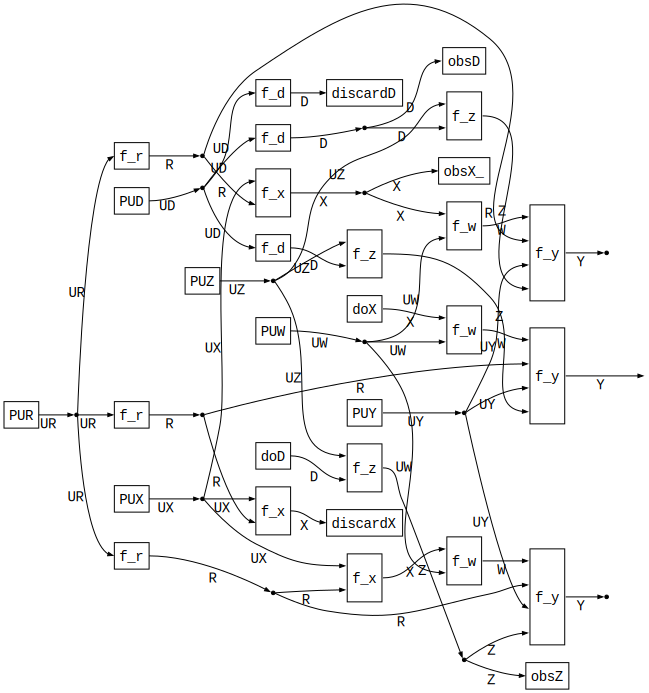

In [4]:
prog_three_worlds = @program CausalR () begin

    ux = PUX()
    uw = PUW()
    uy = PUY()
    uz = PUZ()
    ud = PUD()
    ur = PUR()

    #world 1: do(X = x)
    r1  = f_r(ur)
    x1_unused = f_x(ux, r1)
    _ = discardX(x1_unused)
    x1  = doX()
    w1  = f_w(x1, uw)
    d1  = f_d(ud)
    z1  = f_z(uz, d1)
    y1  = f_y(w1, r1, uy, z1)

    # world 2: actual world, observe X=x̃, D=d
    r2  = f_r(ur)
    x2  = f_x(ux, r2)
    _x2_obs = obsX_(x2)   # sharp state: X -> I
    w2  = f_w(x2, uw)
    d2  = f_d(ud)
    _d2_obs = obsD(d2)   # sharp state: D -> I
    z2  = f_z(uz, d2)
    y2  = f_y(w2, r2, uy, z2)

    # world 3: do(D=d), observe Z=z
    r3  = f_r(ur)
    x3  = f_x(ux, r3)
    w3  = f_w(x3, uw)
    d3_unused = f_d(ud); _ = discardD(d3_unused)
    d3  = doD()
    z3  = f_z(uz, d3)
    _z3_obs = obsZ(z3)   # sharp state: Z -> I
    y3  = f_y(w3, r3, uy, z3)

    return y1
end

draw(prog_three_worlds)
draw(add_junctions(prog_three_worlds))
# ws = in_wires(prog_three_worlds, 30, 1)
# for w in ws
#     println(port_value(prog_three_worlds, w.target))
# end






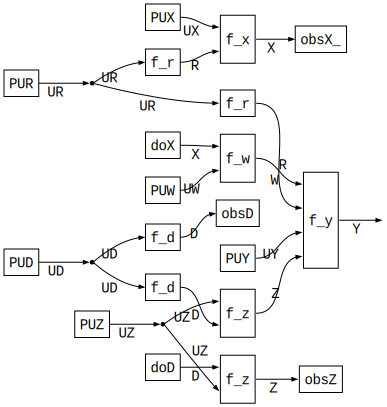

In [5]:
using Catlab
using Catlab.WiringDiagrams
const WD = Catlab.WiringDiagrams

# get box name
box_name(wd::WiringDiagram, b::Int) = begin
    bx = WD.box(wd, b)
    bx === nothing && return nothing
    v = bx.value
    if v isa Symbol
        return v
    elseif v isa NamedTuple
        return (:name ∈ keys(v)) ? v.name : nothing
    elseif v isa Pair
        return v.first
    else
        return nothing
    end
end

function safe_box_name(wd::WiringDiagram, b::Int)
    try
        return box_name(wd, b)
    catch e
        return nothing
    end
end

# count input/output ports
function nin(wd, b::Int)
    # input / output vertices (-2, -1) have no ports
    b <= 0 && return 0
    length(input_ports(wd, b))
end

function nout(wd, b::Int)
    b <= 0 && return 0
    length(output_ports(wd, b))
end


# check if a box is a sharp effect
function is_sharp_effect(wd, b::Int)
    # output / input vertices are never sharp effects
    b <= 0 && return false

    n = box_name(wd, b)
    n isa Symbol || return false
    startswith(String(n), "obs") || return false
    nin(wd, b) == 1 || return false
    nout(wd, b) == 0 || return false
    return true
end




# detect discard boxes: have inputs but no outputs
is_discard_box(wd::WiringDiagram, b::Int) = (nout(wd, b) == 0) && (nin(wd, b) >= 1) && !is_sharp_effect(wd, b)

# check if a box has no consumers (no outgoing wires)
function no_consumers(wd::WiringDiagram, b::Int)
    isempty(out_wires(wd, b))
end

#chech if the box is isolated
function is_lonely_box(wd::WiringDiagram, b::Int)
    nin  = length(input_ports(wd, b))
    nout = length(output_ports(wd, b))

    if nin == 0 && nout == 0
        return true
    end

    connected_to_other_box = false

    for j in 1:nin
        for w in in_wires(wd, b, j)
            sbox = w.source.box
            if sbox != 0 && sbox != b
                connected_to_other_box = true
            end
        end
    end

    for j in 1:nout
        for w in out_wires(wd, b, j)
            tbox = w.target.box
            if tbox != 0 && tbox != b
                connected_to_other_box = true
            end
        end
    end

    return !connected_to_other_box
end

# remove all the isolated box
function remove_lonely_boxes!(wd::WiringDiagram)
    lonely_boxes = Int[]
    for b in 1:WD.nboxes(wd)
        if is_lonely_box(wd, b)
            push!(lonely_boxes, b)
        end
    end

    # Delete in reverse order to avoid index changes
    sort!(lonely_boxes, rev = true)
    for b in lonely_boxes
        WD.rem_box!(wd, b)
    end

    return wd
end

# remove all discard branches and prune dead boxes
function drop_discard_branches!(wd::WiringDiagram)
    changed = true
    while changed
        changed = false
        discards = [b for b in 1:WD.nboxes(wd) if is_discard_box(wd, b)]
        if !isempty(discards)
            for b in reverse(discards)
                for w in reverse(in_wires(wd, b))
                    WD.rem_wire!(wd, w)
                end
                WD.rem_box!(wd, b)
            end
            changed = true
        end
        
        pruned = true
        while pruned
            pruned = false
            for b in reverse(1:WD.nboxes(wd))
                if nout(wd, b) > 0 && no_consumers(wd, b)
                    for w in reverse(in_wires(wd, b))
                        WD.rem_wire!(wd, w)
                    end
                    WD.rem_box!(wd, b)
                    pruned = true
                    changed = true
                end
            end
        end
        
    end
    return wd
end

wd = prog_three_worlds
drop_discard_branches!(wd)
draw(add_junctions(wd))








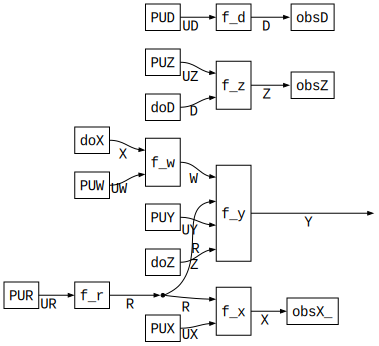

In [6]:


function topological_order(wd::WiringDiagram)
    boxes = WD.box_ids(wd)
    
    indeg = Dict(b => length(WD.in_wires(wd, b)) for b in boxes)

    for b in boxes
        indeg[b] = count(w -> w.source.box != WD.input_id(wd), WD.in_wires(wd, b))
    end

    order = Int[]
    queue = [b for b in boxes if indeg[b] == 0]

    while !isempty(queue)
        v = popfirst!(queue)
        push!(order, v)

        for w in WD.out_wires(wd, v)
            tgt = w.target.box
            tgt == WD.output_id(wd) && continue
            indeg[tgt] -= 1
            if indeg[tgt] == 0
                push!(queue, tgt)
            end
        end
    end

    return order
end

function find_same_name_boxes(wd::WiringDiagram)
    # calculate topological order
    boxes_all = WD.box_ids(wd)

    # calculate indegree
    indeg = Dict(b => 0 for b in boxes_all)
    for b in boxes_all
        indeg[b] = count(w -> w.source.box != WD.input_id(wd), WD.in_wires(wd, b))
    end

    # Kahn topological sorting
    order = Int[]
    queue = [b for b in boxes_all if indeg[b] == 0]
    while !isempty(queue)
        v = popfirst!(queue)
        push!(order, v)
        for w in WD.out_wires(wd, v)
            tgt = w.target.box
            tgt == WD.output_id(wd) && continue
            indeg[tgt] -= 1
            indeg[tgt] == 0 && push!(queue, tgt)
        end
    end

    topo_pos = Dict{Int,Int}()
    for (i, b) in enumerate(order)
        topo_pos[b] = i
    end


    groups = Dict{Symbol,Vector{Int}}()

    for b in 1:WD.nboxes(wd)
        n = safe_box_name(wd, b)
        n isa Symbol && startswith(String(n), "f") || continue
        push!(get!(groups, n, Int[]), b)
    end

    filter!(kv -> length(kv[2]) > 1, groups)


    # remain only the "earliest" group based on topological order
    isempty(groups) && return groups

    # for each name, get the minimum topo position among its boxes
    name_minpos = Dict{Symbol,Int}()
    for (name, boxes) in groups
        name_minpos[name] = minimum(topo_pos[b] for b in boxes)
    end

    global_min = minimum(values(name_minpos))

    # remove all names that are not the global_min, keep only the "earliest" group
    for (name, pos) in name_minpos
        pos == global_min || delete!(groups, name)
    end

    return groups
end


# find_same_name_boxes(wd)


# find input source set for a box
function input_sources_set(wd::WiringDiagram, b::Int)
    S = Set{Symbol}()
    nin = length(input_ports(wd, b))
    for j in 1:nin
        ws = in_wires(wd, b, j)
        for w in ws
            var = port_value(wd, w.source)
            push!(S, var)
        end
    end
    return S
end

# input_sources_set(wd, 7)

# merge identical deterministic boxes
function merge_identical_deterministic_boxes(wd::WiringDiagram)
    flag = true
    while flag
        flag = false
        same_name_boxes = find_same_name_boxes(wd)
        for (name, boxes) in same_name_boxes
            # group boxes by input source set
            groups = Dict{Set{Symbol}, Vector{Int}}()
            for b in boxes
                S = input_sources_set(wd, b)
                push!(get!(groups, S, Int[]), b)
            end
            filter!(kv -> length(kv[2]) > 1, groups)  # remove groups with only one box
            # println(groups)
            if isempty(groups)
                flag = false
                continue
            end
            sub_groups = Set{Int}()
            # merge boxes in each group
            for (S, bs) in groups
                sorted_bs = sort(bs)
                b_keep = first(sorted_bs)
                push!(sub_groups, b_keep)
                for dup in Iterators.reverse(sorted_bs[2:end])
                    for w in out_wires(wd, dup)
                        src_out_idx = w.source.port
                        tgt_box = w.target.box
                        tgt_in_idx = w.target.port

                        pair = (b_keep, src_out_idx) => (tgt_box, tgt_in_idx)
                        if !has_wire(wd, pair)
                            WD.add_wire!(wd, pair)
                        end
                        WD.rem_wire!(wd, w)
                    end
                    WD.rem_box!(wd, dup)
                    flag = true
                end
            end
            # println(1)
            for i in sub_groups
                sharpEffectGroup = Set{Symbol}()
                if length(output_ports(wd, i)) == 1
                    for j in 1:length(output_ports(wd, i))
                        ws = out_wires(wd, i, j)
                        if length(ws) > 1
                            for w in ws
                                tgt_box = w.target.box
                                if is_sharp_effect(wd, tgt_box)
                                    push!(sharpEffectGroup, port_value(wd, w.target))
                                end
                            end
                        end
                        if length(sharpEffectGroup) > 0
                            var_type = first(collect(sharpEffectGroup))
                            for w in ws
                                if port_value(wd, w.target) != var_type || !is_sharp_effect(wd, w.target.box)
                                    tgt_box = w.target.box
                                    tgt_in_idx = w.target.port
                                    WD.rem_wire!(wd, w)
                                    do_box = Box(Symbol("do" * String(var_type)), Any[], Any[var_type])
                                    do_box_id = WD.add_box!(wd, do_box)
                                    WD.add_wire!(wd, (do_box_id, 1) => (w.target.box, tgt_in_idx))
                                else
                                    tgt_box = w.target.box
                                    tgt_in_idx = w.target.port
                                    src_out_idx = w.source.port
                                    WD.rem_wire!(wd, w)
                                    WD.add_wire!(wd, (i, src_out_idx) => (tgt_box, tgt_in_idx))
                                end
                            end    
                        end
                    end
                end
                flag = true
            end
        end
        
    end
    
    remove_lonely_boxes!(wd)
    return wd

end

# merge_identical_deterministic_boxes(wd)

merge_identical_deterministic_boxes(wd)
draw(add_junctions(wd))





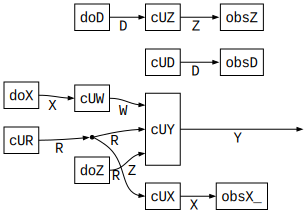

In [7]:


is_state_box(wd::WiringDiagram, b::Int) =
    nin(wd,b) == 0 && nout(wd,b) == 1 && begin
        n = safe_box_name(wd,b)
        n isa Symbol && startswith(String(n), "PU")
    end

function replace_fx_with_cx!(wd::WiringDiagram)
    while true
        changed = false

        # use the topological order
        order = topological_order(wd)
 
        for b in order
            n = box_name(wd, b)
            # search the box startswith "f_"
            n isa Symbol && startswith(String(n), "f_") || continue

            nin_b = nin(wd, b)
            nin_b == 0 && continue

            kept_input_indices = Int[]
            has_state_input = false

            for j in 1:nin_b
                ws = in_wires(wd, b, j)

                #If any wire of this port comes from the state box, it is considered a "λ input"
                if any(is_state_box(wd, w.source.box) for w in ws)
                    has_state_input = true
                else
                    push!(kept_input_indices, j)
                end
            end

            # If this f_box has no λ-state input, it is not the target of step 4.
            has_state_input || continue

            old_in_types  = input_ports(wd, b)
            old_out_types = output_ports(wd, b)

            new_in_types = Any[ old_in_types[j] for j in kept_input_indices ]
            new_out_types = copy(old_out_types)
            state_syms = Symbol[]
            for j in 1:nin_b
                for w in in_wires(wd, b, j)
                    if is_state_box(wd, w.source.box)
                        v = port_value(wd, w.source)
                        v isa Symbol && push!(state_syms, v)
                    end
                end
            end
            isempty(state_syms) && continue
            v = first(state_syms)
            cname = Symbol("c" * String(v))

            # create new "c_box"
            c_box = Box(cname, new_in_types, new_out_types)
            c_id  = WD.add_box!(wd, c_box)


            # Change the wire originally connected to the f_box to connect to the c_box
            for (new_idx, j) in enumerate(kept_input_indices)
                for w in copy(in_wires(wd, b, j))
                    src = w.source
                    WD.rem_wire!(wd, w)
                    WD.add_wire!(wd, (src.box, src.port) => (c_id, new_idx))
                end
            end

            for j in 1:nin_b
                j in kept_input_indices && continue
                for w in copy(in_wires(wd, b, j))
                    WD.rem_wire!(wd, w)
                end
            end

            for ow in copy(out_wires(wd, b))
                src_port_idx = ow.source.port
                tgt_box  = ow.target.box
                tgt_port = ow.target.port
                WD.rem_wire!(wd, ow)
                WD.add_wire!(wd, (c_id, src_port_idx) => (tgt_box, tgt_port))
            end

            # remove the f_box
            WD.rem_box!(wd, b)

            changed = true
            break   # This round only processes one f_box, and then recalculates the topological order.
        end
        changed || break
    end
    remove_lonely_boxes!(wd)
    return wd
end


replace_fx_with_cx!(wd)
draw(add_junctions(wd))





In [8]:
using Catlab
using Catlab.WiringDiagrams
using Catlab.CategoricalAlgebra


struct ConfoundedModel
    directed::Vector{Pair{Symbol, Symbol}}
    latents::Dict{Symbol, Vector{Symbol}}
end

function graph_b_to_scm(model::ConfoundedModel)
    # collect the variable
    structural_nodes = Set{Symbol}()
    for (src, tgt) in model.directed; push!(structural_nodes, src, tgt); end
    
    # Endogenous
    endogenous_vars = sort(collect(structural_nodes))
    
    # Rs
    for (root, children) in model.latents
        push!(structural_nodes, root)
        union!(structural_nodes, children)
    end
    all_nodes = sort(collect(structural_nodes))

    # initialize WD
    output_types = endogenous_vars
    wd = WiringDiagram([], output_types)

    out_port_map = Dict(v => i for (i, v) in enumerate(endogenous_vars))
    node_to_fbox = Dict{Symbol, Int}()
    
    # Get a list of sorted latent variable names for subsequent deterministic traversal
    sorted_latent_roots = sort(collect(keys(model.latents)))

    # create nodes
    for v in all_nodes

        parents = [src for (src, tgt) in model.directed if tgt == v]
        

        for root in sorted_latent_roots
            children = model.latents[root]
            if v in children && root != v
                push!(parents, root)
            end
        end
        
        u_var_name = Symbol("U", v)
        
        f_inputs = Vector{Any}(vcat(parents, [u_var_name]))
        
        # create f_box
        fname = Symbol("f_", v)
        f_box_id = add_box!(wd, Box(fname, f_inputs, [v]))
        node_to_fbox[v] = f_box_id
        
        # create PU Box
        u_name = Symbol("PU_", v)
        u_box_id = add_box!(wd, Box(u_name, [], [u_var_name]))
        
        # connect
        u_port_idx = length(f_inputs)
        add_wire!(wd, Port(u_box_id, OutputPort, 1) => Port(f_box_id, InputPort, u_port_idx))
        
        # output
        if haskey(out_port_map, v)
            out_idx = out_port_map[v]
            add_wire!(wd, Port(f_box_id, OutputPort, 1) => Port(output_id(wd), InputPort, out_idx))
        end
    end
    
    # connect f -> f
    for v in all_nodes
        f_child_id = node_to_fbox[v]
        
        # recollect the parent nodes
        parents = [src for (src, tgt) in model.directed if tgt == v]
        for root in sorted_latent_roots # [FIX 1] 使用相同的排序列表
            children = model.latents[root]
            if v in children && root != v
                push!(parents, root)
            end
        end
        
        for (p_idx, parent) in enumerate(parents)
            f_parent_id = node_to_fbox[parent]
            # Connection: Parent node output -> Corresponding input port of child node
            add_wire!(wd, Port(f_parent_id, OutputPort, 1) => Port(f_child_id, InputPort, p_idx))
        end
    end
    
    return wd
end

graph_b_to_scm (generic function with 1 method)

In [9]:
using Catlab
using Catlab.WiringDiagrams
using Catlab.CategoricalAlgebra

# Define query structure
struct CounterfactualQuery
    world_name::Symbol
    interventions::Dict{Symbol, Symbol}
    observations::Dict{Symbol, Symbol}
    outputs::Vector{Symbol}
end

# Parsing Box Type and Variable Name
function get_node_info(box_val::Any)
    val_str = string(box_val)
    if startswith(val_str, "f_")
        return :Mechanism, Symbol(uppercase(replace(val_str, "f_" => "")))
    elseif startswith(val_str, "PU")
        return :Exogenous, Symbol(val_str)
    else
        return :Other, Symbol(val_str)
    end
end

function build_multiverse(base_wd::WiringDiagram, queries::Vector{CounterfactualQuery})
    
    # Calculate the total output ports
    total_outputs = Symbol[]
    for q in queries; append!(total_outputs, q.outputs); end
    combined = WiringDiagram([], total_outputs)
    
    # Scan the reference image and create an index
    base_pu_ids = Int[]
    base_f_ids = Int[]
    base_id_to_var = Dict{Int, Symbol}() # ID -> :X
    
    for bid in box_ids(base_wd)
        if bid == input_id(base_wd) || bid == output_id(base_wd); continue; end
        type, var = get_node_info(box(base_wd, bid).value)
        
        if type == :Exogenous
            push!(base_pu_ids, bid)
        elseif type == :Mechanism
            push!(base_f_ids, bid)
            base_id_to_var[bid] = var
        end
    end

    # Establish a Global Shared Map
    # Map: Base_PU_ID -> New_Shared_ID
    global_u_map = Dict{Int, Int}()
    for bid in base_pu_ids
        global_u_map[bid] = add_box!(combined, box(base_wd, bid))
    end
    
    # Local World Maps
    # Map: World_Index -> Base_f_ID -> {source: New_ID, sink: New_ID}
    world_maps = Dict{Int, Dict{Int, NamedTuple{(:source, :sink), Tuple{Int, Int}}}}()
    
    for (w_idx, query) in enumerate(queries)
        world_maps[w_idx] = Dict()
        
        for bid in base_f_ids
            b_orig = box(base_wd, bid)
            var_name = base_id_to_var[bid]
            b_outs = output_ports(b_orig)
            
            if haskey(query.interventions, var_name)
                
                # Sink
                sink_id = add_box!(combined, b_orig) 
                
                # Discard
                disc_id = add_box!(combined, Box(Symbol("discard", var_name), b_outs, []))
                for i in 1:length(b_outs)
                    add_wire!(combined, Port(sink_id, OutputPort, i) => Port(disc_id, InputPort, i))
                end
                
                # Source
                do_val = query.interventions[var_name]               # :x
                do_label = Symbol("do_", var_name, "=", do_val)      # :do_X=x
                source_id = add_box!(combined, Box(do_label, [], b_outs))
                
                world_maps[w_idx][bid] = (source = source_id, sink = sink_id)
            else
                # Source = Sink
                new_id = add_box!(combined, b_orig)
                world_maps[w_idx][bid] = (source = new_id, sink = new_id)
            end
            
            # Obs
            if haskey(query.observations, var_name)
                src_id = world_maps[w_idx][bid].source
                obs_val = query.observations[var_name]                 # 例如 :x0 或 :z
                obs_label = Symbol("obs_", var_name, "=", obs_val)     # :obs_X=x0
                obs_id = add_box!(combined, Box(obs_label, b_outs, []))
                for i in 1:length(b_outs)
                    add_wire!(combined, Port(src_id, OutputPort, i) => Port(obs_id, InputPort, i))
                end
            end
        end
    end
    
    # Context-Aware Wiring
    current_out_idx = 1
    
    for (w_idx, query) in enumerate(queries)
        local_map = world_maps[w_idx]
        
        # Reproduce Connection
        for wire in wires(base_wd)
            src_base = wire.source.box
            tgt_base = wire.target.box
            
            if src_base == input_id(base_wd) || src_base == output_id(base_wd) ||
               tgt_base == input_id(base_wd) || tgt_base == output_id(base_wd); continue; end
            
            # find New Source 
            new_src_id = -1
            if haskey(global_u_map, src_base)
                new_src_id = global_u_map[src_base]
            elseif haskey(local_map, src_base)
                new_src_id = local_map[src_base].source
            end
            
            # find New Target
            new_tgt_id = -1
            if haskey(local_map, tgt_base)
                new_tgt_id = local_map[tgt_base].sink
            end
            
            # Connection
            if new_src_id != -1 && new_tgt_id != -1
                add_wire!(combined, Port(new_src_id, OutputPort, wire.source.port) => 
                                    Port(new_tgt_id, InputPort, wire.target.port))
            end
        end
        
        # connect to output
        for req_out in query.outputs
            # check ID 
            for bid in base_f_ids
                if base_id_to_var[bid] == req_out
                    real_src = local_map[bid].source
                    add_wire!(combined, Port(real_src, OutputPort, 1) => 
                                        Port(output_id(combined), InputPort, current_out_idx))
                    current_out_idx += 1
                    break
                end
            end
        end
    end
    
    return combined
end

build_multiverse (generic function with 1 method)

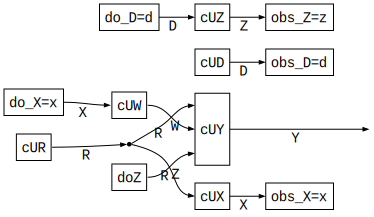

In [21]:

fig_15b_model = ConfoundedModel(
    [
        :X => :W,
        :W => :Y,
        :D => :Z,
        :Z => :Y
    ],
    Dict(
        :R => [:X,:Y]
    )
)

display_var = Set([:D, :Z, :X, :W, :Y])

base_scm = graph_b_to_scm(fig_15b_model)

q1 = CounterfactualQuery(
    :World1, 
    Dict(:X => :x), # Interventions
    Dict{Symbol, Symbol}(),    # No Observations here
    [:Y]              # Output Y
)

q2 = CounterfactualQuery(
    :World2, 
    Dict(),                       # No Interventions
    Dict(:X => :x, :D => :d),            # Observations
    Symbol[]
)

q3 = CounterfactualQuery(
    :World2, 
    Dict(:D => :d),
    Dict(:Z => :z),            # Observations
    Symbol[]
)

queries = [q1, q2, q3]

full_wd = build_multiverse(base_scm, queries)

draw(add_junctions(full_wd))



simplified_wd = full_wd
drop_discard_branches!(simplified_wd)
merge_identical_deterministic_boxes(simplified_wd)
replace_fx_with_cx!(simplified_wd)
draw(add_junctions(simplified_wd))

In [22]:

is_c_mechanism(wd::WiringDiagram, b::Int) = begin
    n = safe_box_name(wd, b)
    n isa Symbol && startswith(String(n), "c")
end

is_root_mechanism(wd::WiringDiagram, b::Int) = begin
    n = safe_box_name(wd, b)
    n isa Symbol && startswith(String(n) , "cUR")
end


# Splitting R-fragment

function find_r_fragments(wd::WiringDiagram)
    boxes = WD.box_ids(wd)

    # All c_* mechanism boxes
    mech_boxes = [b for b in boxes if is_c_mechanism(wd, b)]

    # cX,cY,cZ...（except cR*）
    obs_boxes  = [b for b in mech_boxes if !is_root_mechanism(wd, b)]
    # cR,cR1,cR2...
    root_boxes = [b for b in mech_boxes if  is_root_mechanism(wd, b)]

    obs_set  = Set(obs_boxes)
    root_set = Set(root_boxes)

    # Only record adjacency relationships connected through latent roots
    adj = Dict{Int,Set{Int}}()
    for b in mech_boxes
        adj[b] = Set{Int}()
    end

    # Only root -> observable (a line with object type R) counts as an 'ambiguous connection'
    for r in root_boxes
        for j in 1:nout(wd, r)
            for w in out_wires(wd, r, j)
                tgt = w.target.box
                if tgt in obs_set
                    push!(adj[r], tgt)
                    push!(adj[tgt], r)
                end
            end
        end
    end

    # Run connected components on this graph containing only (root, observable)
    visited   = Set{Int}()
    fragments = Vector{Vector{Int}}()

    for b in mech_boxes
        b in visited && continue
        comp  = Int[]
        stack = [b]
        while !isempty(stack)
            v = pop!(stack)
            v in visited && continue
            push!(visited, v)
            push!(comp, v)
            for nb in adj[v]
                nb in visited || push!(stack, nb)
            end
        end
        push!(fragments, comp)
    end

    # Arrange the boxes inside each fragment in topological order
    topo = topological_order(wd)
    pos  = Dict(b => i for (i,b) in enumerate(topo))
    for frag in fragments
        sort!(frag, by = b -> get(pos, b, typemax(Int)))
    end

    return fragments
end



function show_r_fragments(wd::WiringDiagram)
    frags = find_r_fragments(wd)
    println("Found $(length(frags)) R-fragments:")
    for (i, frag) in enumerate(frags)
        names = [string(safe_box_name(wd, b)) for b in frag]
        println("  Fragment $i: ", join(names, ", "))
    end
    return frags
end

rfrags = show_r_fragments(simplified_wd)

simplified_wd


Found 4 R-fragments:
  Fragment 1: cUR, cUX, cUY
  Fragment 2: cUD
  Fragment 3: cUW
  Fragment 4: cUZ


WiringDiagram([], [:Y], 
[ -2 => {inputs},
  -1 => {outputs},
  1 => Box(:cUY, [:R,:W,:Z], [:Y]),
  2 => Box(:cUX, [:R], [:X]),
  3 => Box(Symbol("obs_X=x"), [:X], []),
  4 => Box(Symbol("obs_D=d"), [:D], []),
  5 => Box(:doZ, [], [:Z]),
  6 => Box(Symbol("do_D=d"), [], [:D]),
  7 => Box(:cUD, [], [:D]),
  8 => Box(:cUR, [], [:R]),
  9 => Box(:cUW, [:X], [:W]),
  10 => Box(Symbol("obs_Z=z"), [:Z], []),
  11 => Box(:cUZ, [:D], [:Z]),
  12 => Box(Symbol("do_X=x"), [], [:X]) ],
[ Wire((6,1) => (11,1)),
  Wire((5,1) => (1,3)),
  Wire((2,1) => (3,1)),
  Wire((11,1) => (10,1)),
  Wire((8,1) => (1,1)),
  Wire((9,1) => (1,2)),
  Wire((7,1) => (4,1)),
  Wire((12,1) => (9,1)),
  Wire((8,1) => (2,1)),
  Wire((1,1) => (-1,1)) ])

In [23]:
is_cX_box(wd, b::Int, var_type::Symbol) = begin
    n = safe_box_name(wd, b)
    a = Symbol("cU", var_type)
    n isa Symbol && n == a
end

function is_sharp_state(wd, b::Int)
    # same idea for doX / doZ / doD
    b <= 0 && return false

    n = box_name(wd, b)
    n isa Symbol || return false
    startswith(String(n), "do") || return false
    nin(wd, b) == 0 || return false
    nout(wd, b) == 1 || return false
    return true
end

function vars_in_fragment(wd, frag_boxes::Vector{Int}, display_var)
    vars = Set{Symbol}()
    for b in frag_boxes
        for w in in_wires(wd, b)
            v = port_value(wd, w.target)
            v isa Symbol && v in display_var && push!(vars, v)
        end
        for w in out_wires(wd, b)
            v = port_value(wd, w.source)
            v isa Symbol && v in display_var && push!(vars, v)
        end
    end
    return collect(vars)
end




vars_in_fragment (generic function with 1 method)

In [24]:
function handle_case1_for_var!(
    wd,
    frag_boxes::Vector{Int},
    var_type::Symbol
)
    # Find all mechanisms cX that generate var_type within the fragment
    cX_boxes = [b for b in frag_boxes if is_cX_box(wd, b, var_type)]
    isempty(cX_boxes) && return :no_cX

    cX = first(cX_boxes)

    # Collect all X-type wires within the fragment
    X_wires = Wire[]
    for b in frag_boxes
        # in port
        for w in in_wires(wd, b)
            if port_value(wd, w.target) == var_type
                push!(X_wires, w)
            end
        end
        # out port
        for w in out_wires(wd, b)
            if port_value(wd, w.source) == var_type
                push!(X_wires, w)
            end
        end
    end

    # Find the X-type output line going out from cX
    cX_out_X_wires = [w for w in out_wires(wd, cX) if port_value(wd, w.source) == var_type]

    # Are any of these output lines connected to the sharp effect?
    has_effect = any(cX_out_X_wires) do w
        tgt = w.target
        tgt_box = tgt.box
        # Connecting to the output (-1) does not count as a sharp effect
        tgt_box < 0 && return false
        is_sharp_effect(wd, tgt_box) && port_value(wd, tgt) == var_type
    end

    #   Case 1.a
    if !has_effect
        # Output of cX has no sharp effect
        # Check: whether there is only this one/few X-shaped lines in the fragment (that is, these outputs of cX)
        if length(X_wires) == length(cX_out_X_wires) &&
           all(w -> w in X_wires, cX_out_X_wires)
            return :case1a_do_nothing
        end
        # else FAIL
    end

    #   Case 1.b 
    if has_effect

        state_sources = Int[]  # record sharp state boxs' id

        for b in frag_boxes
            for w in in_wires(wd, b)
                if port_value(wd, w.target) == var_type
                    src_box = w.source.box

                    # If the output of cX comes from cX itself, skip
                    if src_box == cX
                        continue
                    end

                    # If the source is a sharp state, then make a note of it
                    if is_sharp_state(wd, src_box)
                        push!(state_sources, src_box)
                    else
                        # fail
                        error("FAIL (case1, var=$(var_type)): X-input not from cX or sharp state")
                    end
                end
            end
        end

        unique_states = unique(state_sources)

        if isempty(unique_states)
            # All X usage comes directly from cX (add an effect), and can be seen as a degenerate case of 1.b
            return :case1b_detected
        end

        # Require "value x consistency" for all sharp states
        names = Set{Symbol}()
        for s in unique_states
            n = box_name(wd, s)
            n isa Symbol || error("FAIL: sharp state without Symbol name")
            push!(names, n)
        end

        if length(names) == 1
            # rewiting

            state_box = unique_states[1]  # only one sharp state box

            # Find all within the fragment:
            # 'Exit from this sharp state and feed the X-type input line to the box inside the fragment'
            targets = Tuple{Int,Int}[]  # (tgt_box, tgt_in_port)
            wires_to_remove = Wire[]

            for b in frag_boxes
                for w in in_wires(wd, b)
                    if port_value(wd, w.target) == var_type &&
                       w.source.box == state_box
                        push!(targets, (w.target.box, w.target.port))
                        push!(wires_to_remove, w)
                    end
                end
            end

            # Delete these wires coming out of the sharp state
            for w in wires_to_remove
                WD.rem_wire!(wd, w)
            end

            # Delete this sharp state box itself (doX is no longer needed in this fragment)
            WD.rem_box!(wd, state_box)

            # Find the X-type output port index of cX
            x_out_ports = Int[]
            for w in out_wires(wd, cX)
                if port_value(wd, w.source) == var_type
                    push!(x_out_ports, w.source.port)
                end
            end
            var_out_port = isempty(x_out_ports) ? 1 : first(x_out_ports)

            # Fan out the X of cX to all the previous targets (where it was originally fed by state x)
            for (tgt_box, tgt_in) in targets
                pair = (cX, var_out_port) => (tgt_box, tgt_in)
                has_wire(wd, pair) || WD.add_wire!(wd, pair)
            end

            return :case1b_rewritten
        else
            error("FAIL (case1, var=$(var_type)): multiple different sharp states for X in fragment")
        end
    end

    # else FAIL
    error("FAIL (case1, var=$(var_type)): does not satisfy 1.a or 1.b conditions")
end


handle_case1_for_var! (generic function with 1 method)

In [25]:
# function apply_case1_on_all_fragments!(wd, display_var)
#     frags = find_r_fragments(wd)
#     for (i, frag) in enumerate(frags)
#         vars = vars_in_fragment(wd, frag, display_var)
#         for v in vars
#             try
#                 status = handle_case1_for_var!(wd, frag, v)
#                 println("Fragment $(i), var $(v), case1 status = ", status)
#             catch e
#                 println("Case1 FAIL on $(v) in fragment $(i): ", e)
#             end
#         end
#     end
# end

# apply_case1_on_all_fragments!(simplified_wd, display_var)


In [26]:
"""
Case 2: cX is not in the fragment.

- If all the 'in-fragment lines' of type X within the fragment come from the same cX (in another fragment),
and the only thing in between is fan-out (multiple wires) → 2.a: do nothing;

- If all the 'in-fragment lines' of type X within the fragment come from sharp states (e.g., :doX),
  and the names of these sharp states are the same → merge the multiple states into one, then fan-out;

- Otherwise → 2.c: FAIL.
"""
function handle_case2_for_var!(
    wd,
    frag_boxes::Vector{Int},
    var_type::Symbol
)
    #  If the fragment itself has cX, that’s case1, not case2, skip it directly
    if any(b -> is_cX_box(wd, b, var_type), frag_boxes)
        return :skip_case1
    end

    # Collect all X-type wires entering the fragment
    X_input_wires = Wire[]
    for b in frag_boxes
        for w in in_wires(wd, b)
            tgt = w.target
            src = w.source
            if !(src.box in frag_boxes) && port_value(wd, tgt) == var_type
                push!(X_input_wires, w)
            end
        end
    end

    isempty(X_input_wires) && return :skip_no_X_input

    # check the source
    src_boxes = [w.source.box for w in X_input_wires]
    unique_srcs = unique(src_boxes)

    # All sources are the same cX (in another fragment)
    if length(unique_srcs) == 1
        s = unique_srcs[1]
        if is_cX_box(wd, s, var_type)
            # do nothing
            return :case2a_do_nothing
        end
    end

    # All sources are sharp state (doX/doZ...), and it is the 'same x'
    all_sharp = all(s -> is_sharp_state(wd, s), unique_srcs)
    if all_sharp
        # check if they are the same state
        names = Set{Symbol}()
        for s in unique_srcs
            n = box_name(wd, s)
            n isa Symbol || error("FAIL: sharp state without Symbol name")
            push!(names, n)
        end

        if length(names) == 1
            # rewirte
            # Merge multiple states into one (keeping the first), and feed all X_input_wires from this state.
            keep = unique_srcs[1]
            keep_name = box_name(wd, keep)

            # Delete all X_input_wires
            for w in X_input_wires
                WD.rem_wire!(wd, w)
            end

            # Remove the extra sharp state boxes, keep only the necessary ones
            for s in unique_srcs
                s == keep && continue
                WD.rem_box!(wd, s)
            end

            # Fan out the output of keep to all the original X inputs
            for w in X_input_wires
                tgt = w.target
                WD.add_wire!(wd, (keep, 1) => (tgt.box, tgt.port))
            end

            return :case2b_rewritten
        end
    end

    # else fail
    error("FAIL (case2, var=$(var_type)): X-input wires come from mixed or invalid sources")
end


handle_case2_for_var!

In [27]:

# function apply_case2_on_all_fragments!(wd, display_var)
#     frags = find_r_fragments(wd)
#     for (i, frag) in enumerate(frags)
#         vars = vars_in_fragment(wd, frag, display_var)
#         for v in vars
#             try
#                 status = handle_case2_for_var!(wd, frag, v)
#                 println("Fragment $(i), var $(v), status = ", status)
#             catch e
#                 println("Case2 FAIL on $(v) in fragment $(i): ", e)
#             end
#         end
#     end
# end

# apply_case2_on_all_fragments!(simplified_wd, display_var)



In [28]:
# draw(add_junctions(simplified_wd))


In [29]:
struct WireInfo
    var::Symbol
    src_box::Int
    src_port::Int
    tgt_box::Int
    tgt_port::Int
end

"""
Generate the name of a probability box based on 4 sets of variable types:
P(C_l, F_l^out ; do(D_l), do(F_l^in))

For example:
Cl_vars = [:Y]
Fout_vars = [:Z, :W]
Dl_vars = [:X]
Fin_vars = [:D]

This gives Symbol("P(Y,Z,W ; do(X),do(D))").

frag_id is optional and can be used to mark which fragment it is, e.g., P_1(...)
"""
function make_prob_box_name(
    Cl_vars::Vector{Symbol},
    Fout_vars::Vector{Symbol},
    Dl_vars::Vector{Symbol},
    Fin_vars::Vector{Symbol};
    frag_id::Union{Nothing,Int}=nothing,
)
    # sort
    Cls   = sort!(copy(Cl_vars))
    Fouts = sort!(copy(Fout_vars))
    Dls   = sort!(copy(Dl_vars))
    Fins  = sort!(copy(Fin_vars))

    # Convert a set of variables into a string in the form "X,Y"
    set_str(vs::Vector{Symbol}) =
        isempty(vs) ? "∅" : join(string.(vs), ",")

    C_str    = set_str(Cls)
    Fout_str = set_str(Fouts)
    D_str    = set_str(Dls)
    Fin_str  = set_str(Fins)

    left_parts  = String[]   # left: C_l, F_l^out
    right_parts = String[]   # right: do(D_l), do(F_l^in)

    if !isempty(Cls)
        push!(left_parts, C_str)
    end
    if !isempty(Fouts)
        push!(left_parts, Fout_str)
    end

    if !isempty(Dls)
        push!(right_parts, "do(" * D_str * ")")
    end
    if !isempty(Fins)
        push!(right_parts, "do(" * Fin_str * ")")
    end

    left  = isempty(left_parts)  ? "∅" : join(left_parts, ",")
    right = isempty(right_parts) ? "∅" : join(right_parts, ",")

    label = "P(" * left * " ; " * right * ")"

    if frag_id !== nothing
        label = "P_$frag_id" * label[2:end]
    end

    return Symbol(label)
end

"""
Step 4.2:
Replace the rewritten R-fragment `frag_boxes` with a probability box P(C_l, F_l^out ; do(D_l), do(F_l^in)).

- Ports are organized by "variable sets":
Input = all variable types of D_l + all variable types of F_l^in
Output = all variable types of C_l + all variable types of F_l^out
- Each variable type occupies only one port in each group,
  multiple wires connect to this port through fan-out.

Parameters:
wd : WiringDiagram
frag_boxes : List of box ids in the current fragment
frag_id : Number of the fragment (only affects naming)

Returns:
The id of the newly created probability box
"""
function replace_fragment_with_prob_box_grouped!(
    wd,
    frag_boxes::Vector{Int},
    frag_id::Int,
)
    # Collect the boundary wires of the fragment
    incoming = Wire[]   # outside -> fragment
    outgoing = Wire[]   # fragment -> outside

    for b in frag_boxes
        for w in in_wires(wd, b)
            if !(w.source.box in frag_boxes)
                push!(incoming, w)
            end
        end
        for w in out_wires(wd, b)
            if !(w.target.box in frag_boxes)
                push!(outgoing, w)
            end
        end
    end

    # Group into 4 Dicts by Variable Type
    Dl_map   = Dict{Symbol, Vector{WireInfo}}()  # D_l: input from sharp state
    Fin_map  = Dict{Symbol, Vector{WireInfo}}()  # F_l^in: other input
    Cl_map   = Dict{Symbol, Vector{WireInfo}}()  # C_l: output to sharp effect 
    Fout_map = Dict{Symbol, Vector{WireInfo}}()  # F_l^out: other output

    # Input edge: sharp state vs non-state
    for w in incoming
        vt = port_value(wd, w.target)
        sb, sp = w.source.box, w.source.port
        tb, tp = w.target.box, w.target.port
        info = WireInfo(vt, sb, sp, tb, tp)

        if is_sharp_state(wd, sb)
            push!(get!(Dl_map, vt, WireInfo[]), info)
        else
            push!(get!(Fin_map, vt, WireInfo[]), info)
        end
    end

    # Output edge: sharp effect vs non-effect
    for w in outgoing
        vt = port_value(wd, w.source)
        sb, sp = w.source.box, w.source.port
        tb, tp = w.target.box, w.target.port
        info = WireInfo(vt, sb, sp, tb, tp)

        if is_sharp_effect(wd, tb)
            push!(get!(Cl_map, vt, WireInfo[]), info)
        else
            push!(get!(Fout_map, vt, WireInfo[]), info)
        end
    end

    # delete all
    for b in frag_boxes
        for w in in_wires(wd, b)
            WD.rem_wire!(wd, w)
        end
        for w in out_wires(wd, b)
            WD.rem_wire!(wd, w)
        end
    end
    # for b in frag_boxes
    #     WD.rem_box!(wd, b)
    # end

    Dl_vars   = sort(collect(keys(Dl_map)))    # D_l 
    Fin_vars  = sort(collect(keys(Fin_map)))   # F_l^in
    Cl_vars   = sort(collect(keys(Cl_map)))    # C_l
    Fout_vars = sort(collect(keys(Fout_map)))  # F_l^out

    in_types  = vcat(Dl_vars,  Fin_vars)
    out_types = vcat(Cl_vars, Fout_vars)

    # Generate name: P(C_l,F_l^out ; do(D_l),do(F_l^in))
    P_name = make_prob_box_name(Cl_vars, Fout_vars, Dl_vars, Fin_vars;
                                frag_id = frag_id)

    P_box = Box(P_name, Any[in_types...], Any[out_types...])
    P_id  = WD.add_box!(wd, P_box)

    Dl_index   = Dict{Symbol, Int}()
    Fin_index  = Dict{Symbol, Int}()
    Cl_index   = Dict{Symbol, Int}()
    Fout_index = Dict{Symbol, Int}()

    for (i, vt) in enumerate(Dl_vars)
        Dl_index[vt] = i
    end
    for (k, vt) in enumerate(Fin_vars)
        Fin_index[vt] = length(Dl_vars) + k
    end

    for (i, vt) in enumerate(Cl_vars)
        Cl_index[vt] = i
    end
    for (k, vt) in enumerate(Fout_vars)
        Fout_index[vt] = length(Cl_vars) + k
    end

    # Connect the external endpoint to the P box

    # D_l
    for (vt, infos) in Dl_map
        info = first(infos)
        in_idx = Dl_index[vt]
        WD.add_wire!(wd, (info.src_box, info.src_port) => (P_id, in_idx))
    end

    # F_l^in
    for (vt, infos) in Fin_map
        info = first(infos)
        in_idx = Fin_index[vt]
        WD.add_wire!(wd, (info.src_box, info.src_port) => (P_id, in_idx))
    end

    # C_l
    for (vt, infos) in Cl_map
        out_idx = Cl_index[vt]
        for info in infos
            WD.add_wire!(wd, (P_id, out_idx) => (info.tgt_box, info.tgt_port))
        end
    end

    # F_l^out
    for (vt, infos) in Fout_map
        out_idx = Fout_index[vt]
        for info in infos
            WD.add_wire!(wd, (P_id, out_idx) => (info.tgt_box, info.tgt_port))
        end
    end

    return P_id
end


replace_fragment_with_prob_box_grouped!

---- Step 4.1 on R-fragment #1 ----
  Fragment 1, var Z, case2 = case2b_rewritten
  Fragment 1, var W, case2 = case2a_do_nothing
  Fragment 1, var X, case1 = case1b_detected
  Fragment 1, var Y, case1 = case1a_do_nothing
---- Step 4.1 on R-fragment #2 ----
  Fragment 2, var D, case1 = case1b_detected
---- Step 4.1 on R-fragment #3 ----
  Fragment 3, var W, case1 = case1a_do_nothing
  Fragment 3, var X, case2 = case2b_rewritten
---- Step 4.1 on R-fragment #4 ----
  Fragment 4, var Z, case1 = case1b_detected
  Fragment 4, var D, case2 = case2b_rewritten
---- Step 4.2: collapsing R-fragment #1 ----
---- Step 4.2: collapsing R-fragment #2 ----
---- Step 4.2: collapsing R-fragment #3 ----
---- Step 4.2: collapsing R-fragment #4 ----


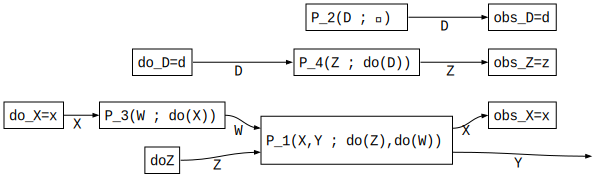

In [30]:
function id_cf_step4!(wd, display_vars)

    # R-fragments are computed once on the original diagram
    r_frags = find_r_fragments(wd)

    # Step 4.1 on ALL fragments
    for (l, frag_boxes) in enumerate(r_frags)
        println("---- Step 4.1 on R-fragment #$l ----")

        # variables in this fragment ∩ display_vars
        frag_vars = vars_in_fragment(wd, frag_boxes, display_vars)

        for v in frag_vars
            try
                # Case 1: c_X is inside the fragment
                status1 = handle_case1_for_var!(wd, frag_boxes, v)

                if status1 == :no_cX
                    # Case 2: c_X is not inside the fragment
                    status2 = handle_case2_for_var!(wd, frag_boxes, v)
                    println("  Fragment $l, var $v, case2 = $status2")
                else
                    println("  Fragment $l, var $v, case1 = $status1")
                end

            catch e
                # corresponds to “Else output FAIL”
                println("  FAIL in fragment $l, var $v: ", e)
                rethrow(e)
            end
        end
    end


    # Step 4.2 — collapse each fragment into a prob box
    for (l, frag_boxes) in enumerate(r_frags)
        println("---- Step 4.2: collapsing R-fragment #$l ----")
        replace_fragment_with_prob_box_grouped!(wd, frag_boxes, l)
    end
    
    remove_lonely_boxes!(wd)
    return wd
end



wd = id_cf_step4!(simplified_wd, display_var)
draw(add_junctions(wd))